Here we load the encoded images and train an SVM classifier

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib

from scipy import interp
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.svm import SVC, LinearSVC

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
import keras.backend as K

from config import *
from utils import specificity, sensitivity, balanced_accuracy, normalize_float, shuffle_data

Using TensorFlow backend.


In [2]:
# Start timing
start_time = time.time()

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "5"
set_session(tf.Session(config=config))

In [4]:
dtype = np.float32
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_CNN_plus_SVM"

In [5]:
!mkdir -p $result_dir

In [6]:
# load images for visualization
images_train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset_FLAIR_lesions_filled.h5', 'r')
images_holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset_FLAIR_lesions_filled.h5', 'r')

images_X_train = images_train_h5['X']
images_X_holdout = images_holdout_h5['X']

In [7]:
# load encoded data
train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/encoded_x_train-ADNI_trial_7-MS_trial_6-layer_flatten_8.h5', 'r')
holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/encoded_x_holdout-ADNI_trial_7-MS_trial_6-layer_flatten_8.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [8]:
# convert data to numpy arrays
X_train = np.array(X_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.array(X_holdout, dtype=dtype)
y_holdout = np.array(y_holdout)

In [9]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(y_train[y_train==0.])))
print("Number of MS patients: {}".format(len(y_train[y_train==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


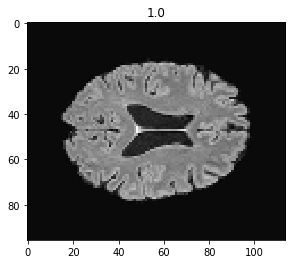

In [10]:
plt.imshow(images_X_train[0][:,:,49], cmap='gray')
plt.title(y_train[0])
plt.show()

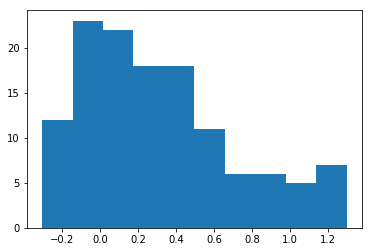

In [11]:
plt.hist(X_train[0])
plt.show()

## Training

In [12]:
X_train.shape

(124, 128)

In [13]:
from sklearn.model_selection import GridSearchCV
#from sklearn import svm, grid_search

def svc_param_selection(X, y, n_folds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(SVC(kernel='linear', gamma='auto'), param_grid, cv=n_folds, n_jobs=5)
    grid_search.fit(X, y)
    grid_search.best_params_
    #print(grid_search.cv_results_)
    return grid_search.best_params_, grid_search.cv_results_

Fold 0


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best paramter value: {'C': 0.1}
######## Training set results ########
Balanced accuracy 96.35 %
Sensitivity 94.74 %
Specificity 97.96 %
######## Validation set results ########
Balanced accuracy 91.67 %
Sensitivity 83.33 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 100.00
Fold 1


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best paramter value: {'C': 0.1}
######## Training set results ########
Balanced accuracy 96.23 %
Sensitivity 96.23 %
Specificity 96.23 %
######## Validation set results ########
Balanced accuracy 95.00 %
Sensitivity 90.00 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 97.50
Fold 2
Best paramter value: {'C': 0.1}
######## Training set results ########
Balanced accuracy 97.17 %
Sensitivity 98.11 %
Specificity 96.23 %
######## Validation set results ########
Balanced accuracy 83.75 %
Sensitivity 80.00 %
Specificity 87.50 %
Area Under the Receiver Operating Curve (ROC AUC score) 88.75
Fold 3


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best paramter value: {'C': 0.1}
######## Training set results ########
Balanced accuracy 94.32 %
Sensitivity 94.64 %
Specificity 94.00 %
######## Validation set results ########
Balanced accuracy 100.00 %
Sensitivity 100.00 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 100.00
Fold 4


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best paramter value: {'C': 0.1}
######## Training set results ########
Balanced accuracy 93.40 %
Sensitivity 90.57 %
Specificity 96.23 %
######## Validation set results ########
Balanced accuracy 100.00 %
Sensitivity 100.00 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 100.00
Fold 5


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best paramter value: {'C': 1}
######## Training set results ########
Balanced accuracy 96.15 %
Sensitivity 92.31 %
Specificity 100.00 %
######## Validation set results ########
Balanced accuracy 87.12 %
Sensitivity 90.91 %
Specificity 83.33 %
Area Under the Receiver Operating Curve (ROC AUC score) 96.97
Fold 6
Best paramter value: {'C': 0.01}
######## Training set results ########
Balanced accuracy 94.41 %
Sensitivity 92.59 %
Specificity 96.23 %
######## Validation set results ########
Balanced accuracy 88.19 %
Sensitivity 88.89 %
Specificity 87.50 %
Area Under the Receiver Operating Curve (ROC AUC score) 94.44
Training Time: 0.0h:0.0m:9.689438104629517s
######## Final results ########
Validation balanced accuracies: 
 [0.9166666666666667, 0.95, 0.8375, 1.0, 1.0, 0.8712121212121212, 0.8819444444444444]
Validation balanced accuracies mean: 0.9224747474747474
Validation final sensitivities: 
 [0.8333333333333334, 0.9, 0.8, 1.0, 1.0, 0.9090909090909091, 0.8888888888888888]
Validation fina

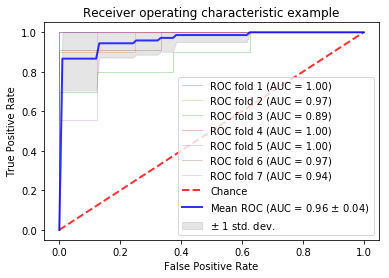

In [14]:
kf = KFold(n_splits=7)
fold = 0

best_params = []
train_balanced_accuracies = []
train_sensitivities = []
train_specificities = []

val_balanced_accuracies = []
val_sensitivities = []
val_specificities = []

auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

# shuffle the data once
X_train, y_train = shuffle_data(X_train, y_train)

# nested cross-validation
for train_idx, test_idx in kf.split(X_train):
    print("Fold %i" %fold)
    fold += 1
    
    # Start inner cross-validation
    best_param, cv_result = svc_param_selection(
        X_train[train_idx],
        y_train[train_idx],
        n_folds=5)
    
    print("Best paramter value: {}".format(best_param))
    
    model = SVC(kernel="linear", C=best_param["C"])
    model.fit(X_train[train_idx], y_train[train_idx])
    
    # training set results
    train_pred = model.predict(X_train[train_idx])
    train_bal_acc = balanced_accuracy(y_train[train_idx], train_pred)
    train_sens = sensitivity(y_train[train_idx], train_pred)
    train_spec = specificity(y_train[train_idx], train_pred)
    # val set results
    val_pred = model.predict(X_train[test_idx])
    val_scores = model.decision_function(X_train[test_idx])
    val_bal_acc = balanced_accuracy(y_train[test_idx], val_pred)
    val_sens = sensitivity(y_train[test_idx], val_pred)
    val_spec = specificity(y_train[test_idx], val_pred)
    
    roc_auc = roc_auc_score(y_train[test_idx], val_scores)
    fpr, tpr, thresholds = roc_curve(y_train[test_idx], val_scores)   
    
    # Store results
    best_params.append(best_param)
    train_balanced_accuracies.append(train_bal_acc)
    train_sensitivities.append(train_sens)
    train_specificities.append(train_spec)
    val_balanced_accuracies.append(val_bal_acc)
    val_sensitivities.append(val_sens)
    val_specificities.append(val_spec)
    
    auc_scores.append(roc_auc)
    # interpolate with diagonal to get comparable results
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0 # correct lowest value after interpolation

    # Print results
    print("######## Training set results ########")
    print("Balanced accuracy {:.2f} %".format(train_bal_acc*100))
    print("Sensitivity {:.2f} %".format(train_sens*100))
    print("Specificity {:.2f} %".format(train_spec*100))
    print("######## Validation set results ########")
    print("Balanced accuracy {:.2f} %".format(val_bal_acc*100))
    print("Sensitivity {:.2f} %".format(val_sens*100))
    print("Specificity {:.2f} %".format(val_spec*100))
    print("Area Under the Receiver Operating Curve (ROC AUC score) {:.2f}".format(roc_auc*100))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (fold, roc_auc))
    
training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
# Print results
print("######## Final results ########")
print("Validation balanced accuracies: \n {}".format(val_balanced_accuracies))
print("Validation balanced accuracies mean: {}".format(np.mean(val_balanced_accuracies)))
print("Validation final sensitivities: \n {}".format(val_sensitivities))
print("Validation final sensitivities' mean: {}".format(np.mean(val_sensitivities)))
print("Validation final specificities: \n {}".format(val_specificities))
print("Validation final specificities' mean: {}".format(np.mean(val_specificities)))
print("Mean ROC AUC score {:.2f}".format(np.mean(auc_scores)*100))

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # correct max value after interpolation and mean
mean_auc = auc(mean_fpr, mean_tpr)
#assert(mean_auc == np.mean(auc_scores))

std_auc = np.std(auc_scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [15]:
training_time = time.time() - start_time

In [16]:
counter = {}

In [17]:
def majority_vote(best_params):
    """
    Find the most often used combination 
    of parameters.
    """
    assert(len(best_params)>=1)
    counter = {}
    # count unique value list
    for i in range(len(best_params)):
        # turn values into key
        new_key = ""
        for x in list(best_params[i].values()):
            new_key = new_key + str(x) + "_"
        if new_key in counter.keys():
            counter[new_key] += 1
        else:
            counter[new_key] = 1
    # select most frequent value list
    majority_param = max(counter, key=lambda key: counter[key])
    # reformat to list
    majority_param = majority_param[:-1].split("_")
    # reformat to dictionary
    result = {}
    for key, value in zip(best_params[0].keys(), majority_param):
        result[key] = value
    return result

In [18]:
majority_param = majority_vote(best_params)
print(majority_param)

{'C': '0.1'}


# Evaluation

Train on the entire training set with the best parameters from above and test on the holdout dataset for final performance.

Trial 0
######## Training set results ########
Balanced accuracy 95.98 %
Sensitivity 95.24 %
Specificity 96.72 %
######## Holdout set results ########
Balanced accuracy 85.00 %
Sensitivity 100.00 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 99.23
Trial 1
######## Training set results ########
Balanced accuracy 95.98 %
Sensitivity 95.24 %
Specificity 96.72 %
######## Holdout set results ########
Balanced accuracy 85.00 %
Sensitivity 100.00 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 99.23
Trial 2
######## Training set results ########
Balanced accuracy 95.98 %
Sensitivity 95.24 %
Specificity 96.72 %
######## Holdout set results ########
Balanced accuracy 85.00 %
Sensitivity 100.00 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 99.23
Trial 3
######## Training set results ########
Balanced accuracy 95.98 %
Sensitivity 95.24 %
Specificity 96.72 %
######## Holdout set results ########
Balanced 

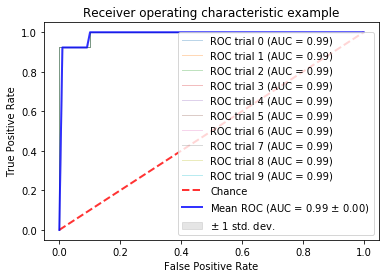

In [19]:
# training args
kernel = "linear"
C = float(majority_param["C"])
model = SVC(kernel=kernel, C=C, cache_size=2000)
#model = LinearSVC(C=C, max_iter=5000)

num_trials = 10

train_balanced_accuracies = []
train_sensitivities = []
train_specificities = []

holdout_balanced_accuracies = []
holdout_sensitivities = []
holdout_specificities = []

auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(num_trials):
    print("Trial %i" %i)
    
    # shuffle the data
    X_train, y_train = shuffle_data(X_train, y_train)
    
    # Start training
    model.fit(X_train, y_train)
    # training set results
    train_pred = model.predict(X_train)
    train_bal_acc = balanced_accuracy(y_train, train_pred)
    train_sens = sensitivity(y_train, train_pred)
    train_spec = specificity(y_train, train_pred)
    # holdout set results
    holdout_pred = model.predict(X_holdout)
    holdout_scores = model.decision_function(X_holdout)
    holdout_bal_acc = balanced_accuracy(y_holdout, holdout_pred)
    holdout_sens = sensitivity(y_holdout, holdout_pred)
    holdout_spec = specificity(y_holdout, holdout_pred)
    
    roc_auc = roc_auc_score(y_holdout, holdout_scores)
    fpr, tpr, thresholds = roc_curve(y_holdout, holdout_scores)   
    
    # Store results
    train_balanced_accuracies.append(train_bal_acc)
    train_sensitivities.append(train_sens)
    train_specificities.append(train_spec)
    holdout_balanced_accuracies.append(holdout_bal_acc)
    holdout_sensitivities.append(holdout_sens)
    holdout_specificities.append(holdout_spec)
    
    auc_scores.append(roc_auc)
    # interpolate with diagonal to get comparable results
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0 # correct lowest value after interpolation

    # Print results
    print("######## Training set results ########")
    print("Balanced accuracy {:.2f} %".format(train_bal_acc*100))
    print("Sensitivity {:.2f} %".format(train_sens*100))
    print("Specificity {:.2f} %".format(train_spec*100))
    print("######## Holdout set results ########")
    print("Balanced accuracy {:.2f} %".format(holdout_bal_acc*100))
    print("Sensitivity {:.2f} %".format(holdout_sens*100))
    print("Specificity {:.2f} %".format(holdout_spec*100))
    print("Area Under the Receiver Operating Curve (ROC AUC score) {:.2f}".format(roc_auc*100))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC trial %d (AUC = %0.2f)' % (i, roc_auc))
    
training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
# Print results
print("######## Final results ########")
print("Holdout balanced accuracies: \n {}".format(holdout_balanced_accuracies))
print("Holdout balanced accuracies mean: {}".format(np.mean(holdout_balanced_accuracies)))
print("Holdout final sensitivities: \n {}".format(holdout_sensitivities))
print("Holdout final sensitivities' mean: {}".format(np.mean(holdout_sensitivities)))
print("Holdout final specificities: \n {}".format(holdout_specificities))
print("Holdout final specificities' mean: {}".format(np.mean(holdout_specificities)))
print("Mean ROC AUC score {:.2f}".format(np.mean(auc_scores)*100))

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # correct max value after interpolation and mean
mean_auc = auc(mean_fpr, mean_tpr)
#assert(mean_auc == np.mean(auc_scores))

std_auc = np.std(auc_scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [20]:
total_time = time.time() - start_time

In [21]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
print("Total time elapsed: {}h:{}m:{}s".format(
            total_time//3600, (total_time//60)%60, total_time%60))

Training Time: 0.0h:0.0m:11.96906304359436s
Total time elapsed: 0.0h:0.0m:13.086587190628052s


In [22]:
quit()